# Calibration overview


An image of the sky contains counts from several sources. The task of data
reduction (another name for image calibration) is to remove all non-celestial
counts from the image and to correct for non-uniform sensitivity.

At the end of the previous notebook we arrived at an expression for the counts
in a science image in terms of the sources of counts:

$$
\text{raw image} = \text{bias} + \text{noise} + \text{dark current} + \text{flat} \times (\text{sky} + \text{stars}).
$$

Solving for the counts just from the stars is as follows:

$$
\text{stars} + \text{noise} = \frac{\text{raw image} - \text{bias} - \text{dark current}}{\text{flat}} - \text{sky}
$$

**It is *impossible* to remove the noise from the raw image because the noise is
random.**

The dark current is typically calculated from a *dark frame* (aka dark image).
Such an image has bias and read noise in it as well, so:

$$
\text{dark current} + \text{noise} = (\text{dark frame} - \text{bias})/(\text{dark exposure time})
$$

Once again, note that the noise cannot be removed.

## This noise cannot be removed from CCD images

To demonstrate that you cannot remove the noise from an image, let's construct
an image with just stars and noise and try to subtract a noise image created
with the same parameters. The amount of noise here is exaggerated to make it
clear in the images. The cell below includes all of the necessary imports and helper functions.

In [9]:
!pip install photutils

import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import os

from astropy.visualization import hist
from astropy.stats import histogram

from astropy.modeling.models import Gaussian2D, RickerWavelet2D, Const2D
from photutils.aperture import EllipticalAperture
from photutils.datasets import make_model_image, make_model_params
from photutils.psf import CircularGaussianPSF

from astropy import visualization as aviz
from astropy.nddata.blocks import block_reduce
from astropy.nddata.utils import Cutout2D
from matplotlib import pyplot as plt

seed = os.getenv('GUIDE_RANDOM_SEED', None)

if seed is not None:
    seed = int(seed)

default_rng = np.random.default_rng(seed)


def read_noise(image, amount, gain=1):
    """
    Generate simulated read noise.

    Parameters
    ----------

    image: numpy array
        Image whose shape the noise array should match.
    amount : float
        Amount of read noise, in electrons.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    shape = image.shape

    noise = default_rng.normal(scale=amount / gain, size=shape)

    return noise


def bias(image, value, realistic=False):
    """
    Generate simulated bias image.

    Parameters
    ----------

    image: numpy array
        Image whose shape the bias array should match.
    value: float
        Bias level to add.
    realistic : bool, optional
        If ``True``, add some clomuns with somewhat higher bias value
        (a not uncommon thing)
    """
    # This is the whole thing: the bias is really suppose to be a constant
    # offset!
    bias_im = np.zeros_like(image) + value

    # If we want a more realistic bias we need to do a little more work.
    if realistic:
        shape = image.shape
        number_of_colums = 5

        # We want a random-looking variation in the bias, but unlike the
        # readnoise the bias should *not* change from image to image, so we
        # make sure to always generate the same "random" numbers.
        rng = np.random.RandomState(seed=8392)  # 20180520
        columns = rng.randint(0, shape[1], size=number_of_colums)
        # This adds a little random-looking noise into the data.
        col_pattern = rng.randint(0, int(0.1 * value), size=shape[0])

        # Make the chosen columns a little brighter than the rest...
        for c in columns:
            bias_im[:, c] = value + col_pattern

    return bias_im


def dark_current(image, current, exposure_time, gain=1.0, hot_pixels=False):
    """
    Simulate dark current in a CCD, optionally including hot pixels.

    Parameters
    ----------

    image : numpy array
        Image whose shape the cosmic array should match.
    current : float
        Dark current, in electrons/pixel/second, which is the way
        manufacturers typically report it.
    exposure_time : float
        Length of the simulated exposure, in seconds.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    hot_pixels : bool, optional
        If ``True``, add hot pixels to the image.

    Returns
    -------

    numpy array
        An array the same shape and dtype as the input containing dark counts
        in units of ADU.
    """

    # dark current for every pixel; we'll modify the current for some pixels if
    # the user wants hot pixels.
    base_current = current * exposure_time / gain

    # This random number generation should change on each call.
    dark_im = default_rng.poisson(base_current, size=image.shape)

    if hot_pixels:
        # We'll set 0.01% of the pixels to be hot; that is probably too high
        # but should ensure they are visible.
        y_max, x_max = dark_im.shape

        n_hot = int(0.0001 * x_max * y_max)

        # Like with the bias image, we want the hot pixels to always be in the
        # same places (at least for the same image size) but also want them to
        # appear to be randomly distributed. So we set a random number seed to
        # ensure we always get the same thing.
        rng = np.random.RandomState(16201649)
        hot_x = rng.randint(0, x_max, size=n_hot)
        hot_y = rng.randint(0, y_max, size=n_hot)

        hot_current = 10000 * current

        dark_im[(hot_y, hot_x)] = hot_current * exposure_time / gain

    return dark_im


def sky_background(image, sky_counts, gain=1):
    """
    Generate sky background, optionally including a gradient across the
    image (because some times Moons happen).

    Parameters
    ----------

    image : numpy array
        Image whose shape the cosmic array should match.
    sky_counts : float
        The target value for the number of counts (as opposed to electrons or
        photons) from the sky.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    sky_im = default_rng.poisson(sky_counts * gain, size=image.shape) / gain

    return sky_im


def stars(image, number, max_counts=10000, gain=1, fwhm=4):
    """
    Add some stars to the image.
    """
    psf_model = CircularGaussianPSF(fwhm=fwhm)
    max_counts *= 100  # approx. peak amplitude to flux
    params = make_model_params(image.shape, n_sources=number,
                               flux=(max_counts / 10, max_counts),
                               min_separation=20,
                               border_size=20, seed=12345)

    return make_model_image(image.shape, psf_model, params,
                            progress_bar=True)


def make_cosmic_rays(image, number, strength=10000):
    """
    Generate an image with a few cosmic rays.

    Parameters
    ----------

    image numpy array
        Image whose shape the cosmic array should match.
    number: float
        Number of cosmic rays to add to the image.
    strength : float, optional
        Pixel count in the cosmic rays.
    """

    cr_image = np.zeros_like(image)

    # Yes, the order below is correct. The x axis is the column, which
    # is the second index.
    max_y, max_x = cr_image.shape

    # Get the smallest dimension to ensure the cosmic rays are within the image
    maximum_pos = np.min(cr_image.shape)
    # These will be center points of the cosmic rays, which we place away from
    # the edges to ensure they are visible.
    xy_cr = default_rng.integers(0.1 * maximum_pos, 0.9 * maximum_pos,
                                 size=[number, 2])

    cr_length = 5  # pixels, a little big
    cr_width = 2
    theta_cr = 2 * np.pi * default_rng.uniform()
    apertures = EllipticalAperture(xy_cr, cr_length, cr_width, theta_cr)
    masks = apertures.to_mask(method='center')
    for mask in masks:
        cr_image += strength * mask.to_image(shape=cr_image.shape)

    return cr_image


# Functions related to simulated flat images

def make_one_donut(center, diameter=10, amplitude=0.25):
    sigma = diameter / 2
    mh = RickerWavelet2D(amplitude=amplitude,
                      x_0=center[0], y_0=center[1],
                      sigma=sigma)
    gauss = Gaussian2D(amplitude=amplitude,
                       x_mean=center[0], y_mean=center[1],
                       x_stddev=sigma, y_stddev=sigma)
    return Const2D(amplitude=1) + (mh - gauss)


def add_donuts(image, number=20):
    """
    Create a transfer function, i.e. matrix by which you multiply
    input counts to obtain actual counts.

    Parameters
    ----------


    image : numpy array
        Image whose shape the cosmic array should match.

    number : int, optional
        Number of dust donuts to add.
    """

    y, x = np.indices(image.shape)

    # The dust donuts should always be in the same place...
    rng = np.random.RandomState(43901)
    shape = np.array(image.shape)
    border_padding = 50

    # We'll make the dust specks range from 1% to 5% of the image size, but
    # only in a couple of sizes. The dust grains themselves are fairly uniform
    # in size (I think), and there are only a fwe elements on which dust can
    # settle. Size on the image is determined by size of the dust and how far
    # it is from the CCD chip.

    min_diam = int(0.02 * shape.max())
    max_diam = int(0.05 * shape.max())

    # Weight towards the smaller donuts because it looks more like real flats..
    diameters = rng.choice([min_diam, min_diam, min_diam, max_diam],
                           size=number)

    # Add a little variation in amplitude
    amplitudes = rng.normal(0.25, 0.05, size=number)
    center_x = rng.randint(border_padding,
                           high=shape[1] - border_padding, size=number)
    center_y = rng.randint(border_padding,
                           high=shape[0] - border_padding, size=number)
    centers = [[x, y] for x, y in zip(center_x, center_y)]

    donut_model = make_one_donut(centers[0], diameter=diameters[0],
                                 amplitude=amplitudes[0])
    donut_im = donut_model(x, y)
    idx = 1
    for center, diam, amplitude in zip(centers[1:],
                                       diameters[1:],
                                       amplitudes[1:]):
        idx += 1
        donut_model = make_one_donut(center, diameter=diam,
                                      amplitude=amplitude)
        donut_im += donut_model(x, y)

    donut_im /= number

    return donut_im


def sensitivity_variations(image, vignetting=True, dust=True):
    """
    Create a transfer function, i.e. matrix by which you multiply input
    counts to obtain actual counts.

    Parameters
    ----------


    image : numpy array
        Image whose shape the cosmic array should match.

    vignetting : bool, optional
        If ``True``, darken image near corners.

    dust : bool, optional
        If ``True``, add some plausible-looking dust.
    """

    sensitivity = np.zeros_like(image) + 1.0
    shape = np.array(sensitivity.shape)

    if dust or vignetting:
        # Yes, this should be y, x.
        y, x = np.indices(sensitivity.shape)

    if vignetting:
        # Generate very wide gaussian centered on the center of the image,
        # multiply the sensitivity by it.
        vign_model = Gaussian2D(amplitude=1,
                                x_mean=shape[0] / 2, y_mean=shape[1] / 2,
                                x_stddev=2 * shape.max(),
                                y_stddev=2 * shape.max())
        vign_im = vign_model(x, y)
        sensitivity *= vign_im

    if dust:
        dust_im = add_donuts(image, number=40)
        dust_im = dust_im / dust_im.max()
        sensitivity *= dust_im

    return sensitivity

def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='viridis', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriat stretching.

    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """
    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)


    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()

    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio

    reduced_data = block_reduce(image, ratio)

    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2

    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)


### First, some stars with noise

The image below shows stars (the larger "blobs" in the image) but shows quite a
bit of noise as well (the much smaller "dots").

Add model sources:   0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Stars with noise')

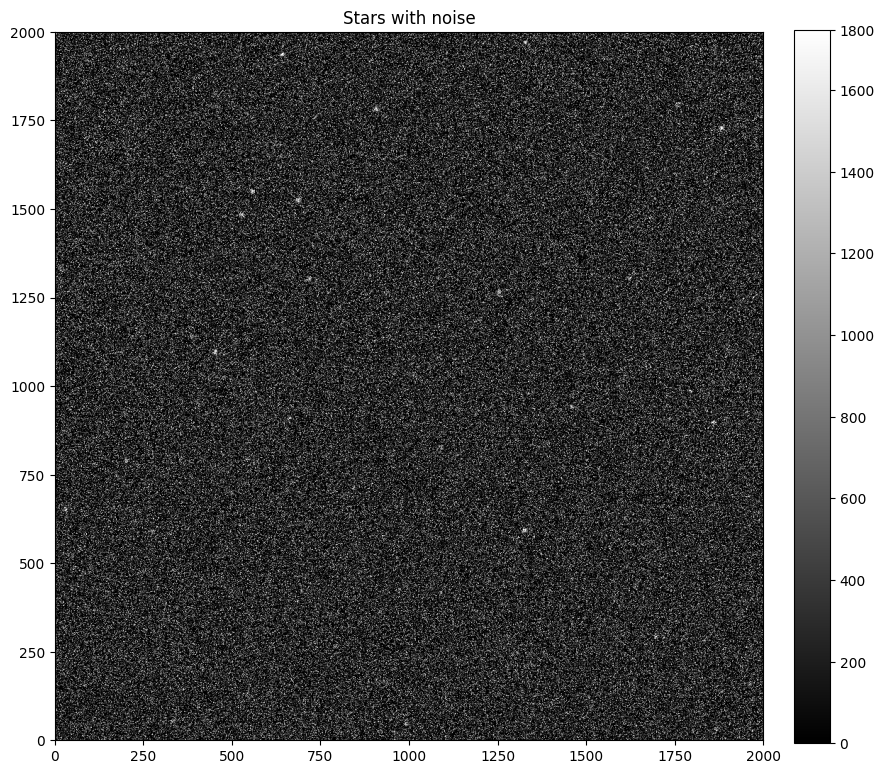

In [10]:
image = np.zeros([2000, 2000])
gain = 1.0
noise_amount = 1500

stars_with_noise = stars(image, 50, max_counts=2500, fwhm=10) + read_noise(image, noise_amount, gain=gain)

show_image(stars_with_noise, cmap='gray', percu=50)
plt.title('Stars with noise')

### Now an *incorrect* attempt at reducing noise

Notice that the call to the noise function has exactly the same arguments as
above, in much the same way your camera's electronics will have the same noise
properties every time you read out an image.

However, the amount of noise has **increased**, not decreased. It's much harder
to pick out the stars in this image.

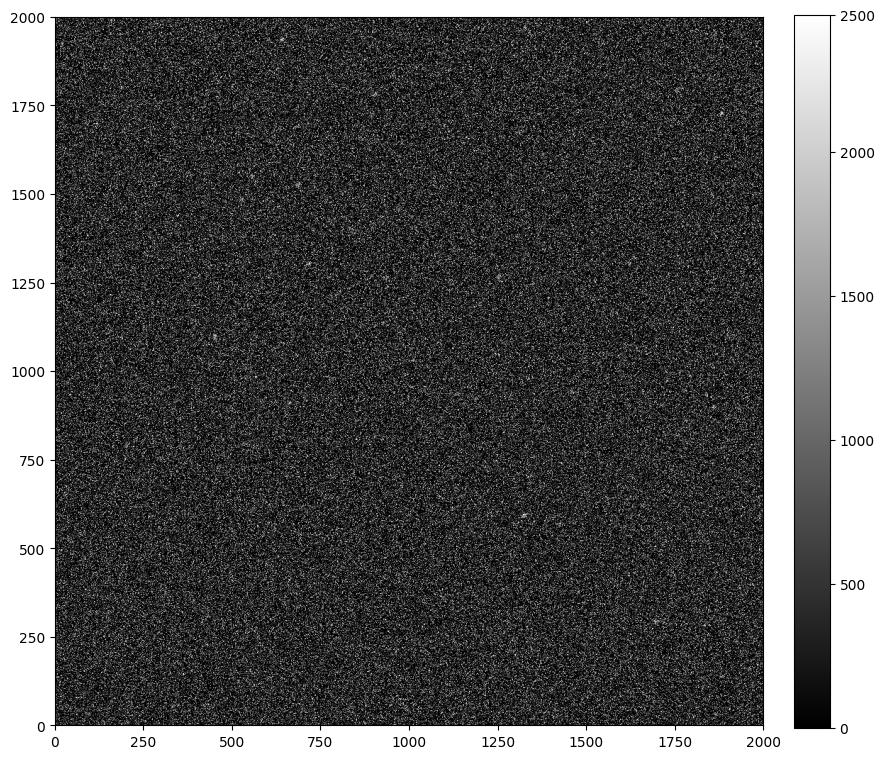

In [13]:
incorrect_attempt_to_remove_noise = stars_with_noise - read_noise(image, noise_amount, gain=gain)

show_image(incorrect_attempt_to_remove_noise, cmap='gray', percu=50)

## Every image has noise

Every image, including calibration images like bias and dark frames, has noise.
If we tried to calibrate images by taking a single bias image and a single dark
image, the final result might well look worse than before the image is reduced.

For demonstration, we'll see what happens below.

Note that here we construct *realistic* bias and dark, but leave read noise out
of the flat; we'll return to that point later.

### First, set parameters for the CCD

These are the same as in the previous notebook, except for the read noise, which
is 700$e-$, 100 times larger than in the previous notebook.

In [14]:
gain = 1.0
star_exposure = 30.0
dark_exposure = 60.0
dark = 0.1
sky_counts = 20
bias_level = 1100
read_noise_electrons = 700
max_star_counts = 2000

### Generate the images, with noise

In [15]:
bias_with_noise = (bias(image, bias_level, realistic=True) +
                   read_noise(image, read_noise_electrons, gain=gain))

dark_frame_with_noise = (bias(image, bias_level, realistic=True) +
                         dark_current(image, dark, dark_exposure, gain=gain, hot_pixels=True) +
                         read_noise(image, read_noise_electrons, gain=gain))

flat = sensitivity_variations(image)

In [16]:
realistic_stars = (stars(image, 50, max_counts=max_star_counts) +
                   dark_current(image, dark, star_exposure, gain=gain, hot_pixels=True) +
                   bias(image, bias_level, realistic=True) +
                   read_noise(image, read_noise_electrons, gain=gain)
                  )

Add model sources:   0%|          | 0/50 [00:00<?, ?it/s]

### Uncalibrated image

Below we display the uncalibrated image; in a moment we'll compare it to the
calibrated version. Even though they don't stand out there really are stars in
it.

<Figure size 1200x1200 with 0 Axes>

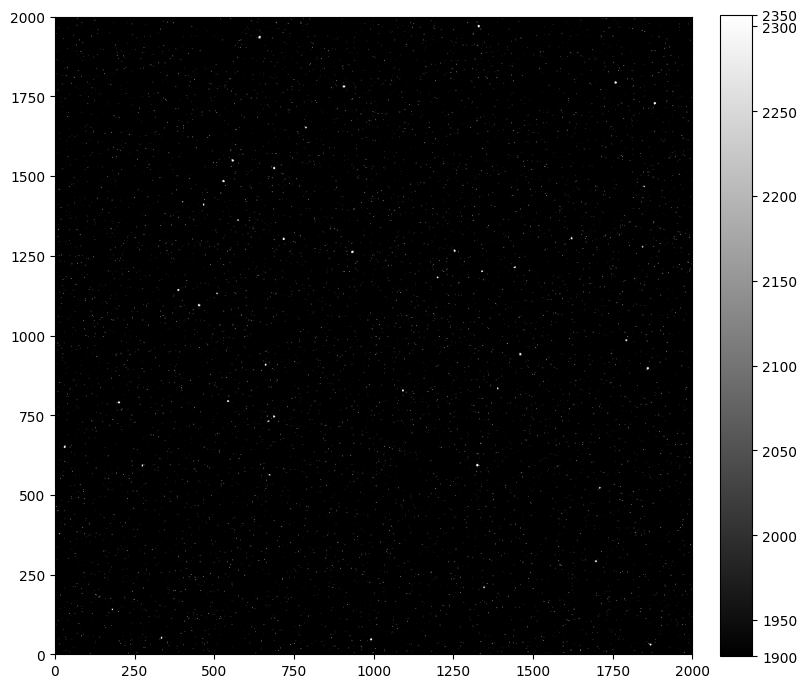

In [17]:
plt.figure(figsize=(12, 12))
show_image(realistic_stars, cmap='gray', percu=99.9, figsize=(9, 9))

### Reduce (calibrate) the star image

First we calculate the dark current, scaled to the exposure time of our light
image.

In [18]:
scaled_dark_current = star_exposure * (dark_frame_with_noise - bias_with_noise) / dark_exposure

Next, we subtract the bias and dark current from the star image and then apply
the flat correction.

In [19]:
calibrated_stars = (realistic_stars - bias_with_noise - scaled_dark_current) / flat

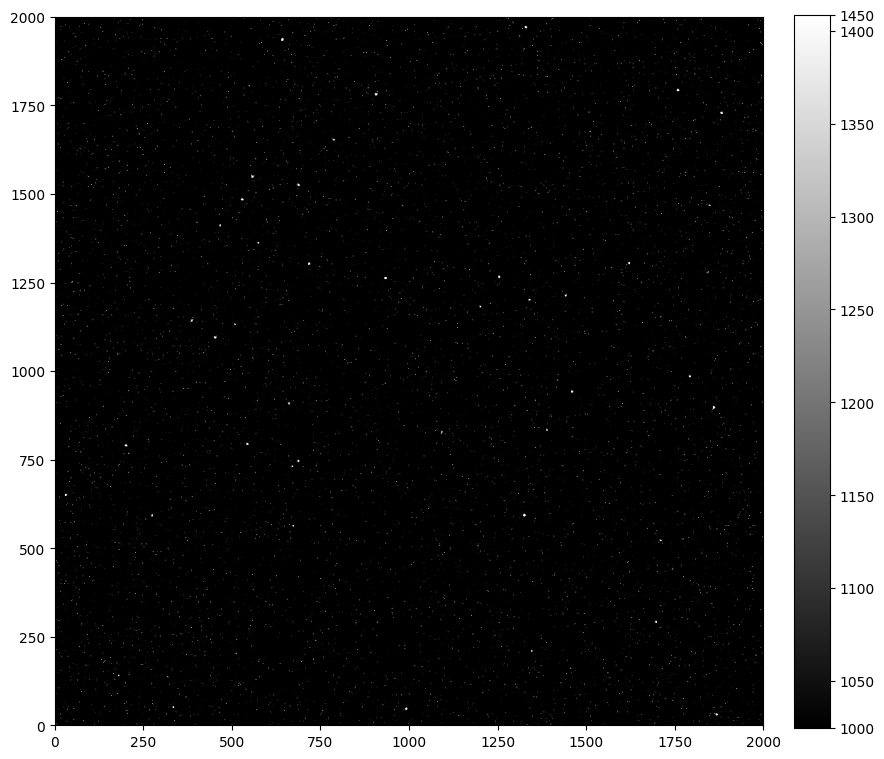

In [20]:
show_image(calibrated_stars, cmap='gray', percu=99.9)

### Reducing the image cleans up the image a bit

The stars stand more clearly than in the unreduced image.

This image does not look *much* better than the uncalibrated image, but remember
that the read noise used in this simulated image, 700 $e^-$ per pixel, is
unrealistically high.

### Reducing the image increases the noise in the image

The histogram below shows pixel values before and after calibration. The width
of the distribution is a measure of the read noise. As expected, reducing the
image increases the read noise. One reason one takes several calibration images
of each type is to reduce the amount of noise in the calibration image. That
will, in turn, keep the noise in the final image as small as possible.

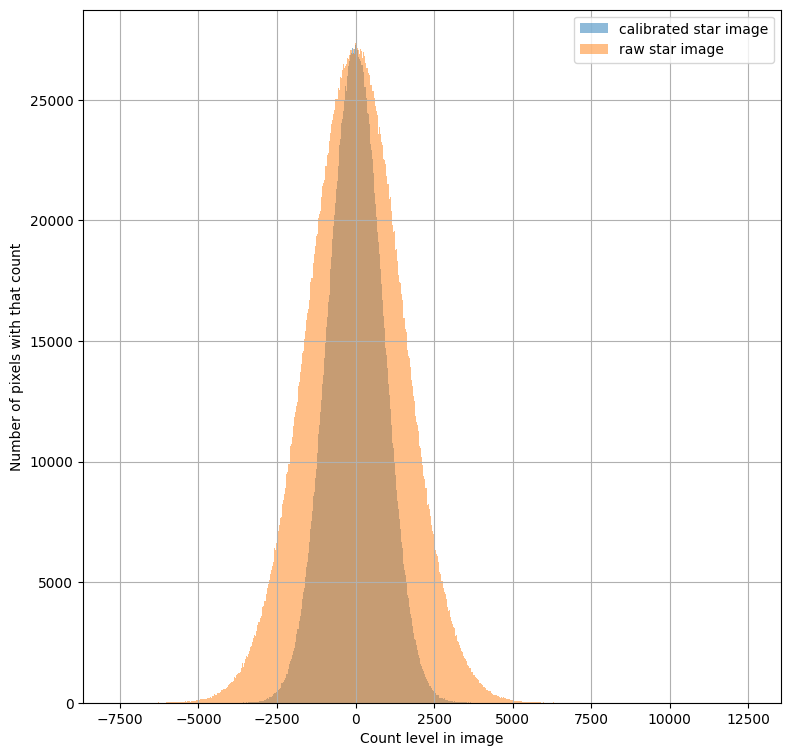

In [21]:
plt.figure(figsize=(9, 9))
hist(calibrated_stars.flatten(), bins='freedman', label='calibrated star image', alpha=0.5)
hist(stars_with_noise.flatten(), bins='freedman', label='raw star image', alpha=0.5)
plt.legend()
plt.grid()
plt.xlabel('Count level in image')
plt.ylabel('Number of pixels with that count');